# Chunking

In [1]:
# from docx import Document
# import json
# from docx.oxml.table import CT_Tbl
# from docx.oxml.text.paragraph import CT_P
# from docx.table import _Cell, Table
# from docx.text.paragraph import Paragraph

In [2]:
# def iterator(parent):
#     """Yield paragraphs and tables in document order."""
#     for child in parent.element.body.iterchildren():
#         if isinstance(child, CT_P):
#             yield Paragraph(child, parent)
#         elif isinstance(child, CT_Tbl):
#             yield Table(child, parent)

In [3]:
# def is_heading(paragraph):
#     """Determine if a paragraph is a heading by checking its style name."""
#     # Common heading styles in Word are: 'Heading 1', 'Heading 2', etc.
#     style_name = paragraph.style.name.lower()
#     return style_name.startswith('heading')

In [4]:
# def docx_extract(file_path):
#     doc = Document(file_path)
#     chunks = []
#     current_heading = "No Heading"
#     current_text_parts = []
#     chunk_id = 1

#     for block in iterator(doc):
#         if isinstance(block, Paragraph):
#             text = block.text.strip()
#             if not text:
#                 continue
#             if is_heading(block):
#                 # Save previous chunk if any
#                 if current_text_parts:
#                     chunks.append({
#                         "heading": current_heading,
#                         "text": "\n\n".join(current_text_parts),
#                         "source": f"chunk_{chunk_id}"
#                     })
#                     chunk_id += 1
#                     current_text_parts = []
#                 current_heading = text  # Start new chunk
#             else:
#                 current_text_parts.append(text)

#         elif isinstance(block, Table):
#             rows_text = []
#             for row in block.rows:
#                 row_texts = [cell.text.strip().replace('\n', ' ') for cell in row.cells]
#                 if any(row_texts):
#                     rows_text.append(" | ".join(row_texts))
#             if rows_text:
#                 table_text = "[TABLE]\n" + "\n".join(rows_text)
#                 current_text_parts.append(table_text)

#     # Save the final chunk
#     if current_text_parts:
#         chunks.append({
#             "heading": current_heading,
#             "text": "\n\n".join(current_text_parts),
#             "source": f"chunk_{chunk_id}"
#         })

#     return chunks


In [5]:
# file_path = "Untitled document.docx" 
# chunks = docx_extract(file_path)

# # Save or print
# with open("doc_chunks.json", "w", encoding="utf-8") as f:
#     json.dump(chunks, f, ensure_ascii=False, indent=2)

# print(f"Extracted {len(chunks)} chunks.")


# Knowledge Graph Creation

In [6]:
%pip install python-docx
%pip install sentence-transformers
%pip install huggingface_hub
%pip install openai
%pip install json-repair
%pip install groq
%pip install langchain langchain-experimental langchainhub langchain-core langchain-community langchain-groq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import os 
from langchain.chat_models import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from docx import Document as docx_doc
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain


In [ ]:
# llm_openai = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     api_key=""  # if you prefer to pass api key in directly instaed of using env vars
# )

os.environ["GROQ_API_KEY"] = "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"

llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.3
)


In [34]:
def extract_chunks_by_heading(file_path):
    doc = docx_doc(file_path)
    chunks = []
    current_heading = "No Heading"
    current_text = []

    for para in doc.paragraphs:
        if para.style.name.startswith("Heading"):
            # Save previous chunk before starting a new one
            if current_text:
                chunks.append(Document(page_content="\n".join(current_text), metadata={"heading": current_heading}))
            current_heading = para.text.strip()
            current_text = []
        else:
            if para.text.strip():
                current_text.append(para.text.strip())

    # Add final chunk
    if current_text:
        chunks.append(Document(page_content="\n".join(current_text), metadata={"heading": current_heading}))

    return chunks


In [46]:
custom_prompt = ChatPromptTemplate.from_template(
    """You are an expert Knowledge Graph Builder and Data Analyst.

Given the following text (which may contain tables, structured data, or paragraphs), extract a **comprehensive set of relationships and insights**, including:

### 1. Entities:
- Real-world items, objects, or concepts mentioned in the text.
- Use **exact phrases** from the input.

### 2. Attributes & Metrics:
- Quantities, mean values, measurements (e.g., "Ant Count: 55.5").
- Include units if specified.

### 3. Relationships:
- Between entities (e.g., "Sandwich —[CONTAINS]→ Butter").
- Between data and entities (e.g., "Butter —[ASSOCIATED_WITH_HIGHER_ANT_COUNT]→ Ant Count: 55.5").

### 4. Analytical Inference:
- Infer insights from **tabular or numeric data**.
- Example:
  - If "Peanut Butter" has the **highest mean ant count**, then add:
    `Peanut Butter —[HAS_HIGHEST_ANT_ATTRACTION]→ Ant Count: 55.5`
  - If "White Bread" has the **lowest mean ant count**, add:
    `White Bread —[HAS_LOWEST_ANT_ATTRACTION]→ Ant Count: 38.1`

### 5. Subcomponents & Hierarchies:
- E.g., "Sandwich —[TOPPED_WITH]→ Ham"
- E.g., "Toppings —[INCLUDES]→ Pickled Gherkins"

### Output Format:
- Use this format for each relationship:
  `Entity A —[Relation]→ Entity B`

- Include analytical facts as their own edges (use meaningful relation names like `HAS_MAX_COUNT`, `CORRELATED_WITH`, etc).

### If nothing meaningful is found, return: []
  
Text:
{input}

Output:
"""
)

In [47]:
def extract_text_from_docx(file_path):
    doc = docx_doc(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return "\n".join(full_text)

heading_chunks = extract_chunks_by_heading("Untitled document.docx")


file_path = "Untitled document.docx"
# text = extract_text_from_docx(file_path)

graph_transformer = LLMGraphTransformer(llm=llm, prompt=custom_prompt)

# doc = [Document(page_content=text)]
graph = graph_transformer.convert_to_graph_documents(heading_chunks)

In [48]:
heading_chunks

[Document(metadata={'heading': 'No Heading'}, page_content='Introduction:\nEconomic Problems:\nA study on the potential of ants to act as vectors of foodborne pathogens - PMC\nMassive yet grossly underestimated global costs of invasive insects | Nature Communications\n\nHealth Hazards:\nA study on the potential of ants to act as vectors of foodborne pathogens - PubMed\n"Ants were found to harbor yeasts and molds systematically (100%), coliforms frequently (52%), Bacillus spp. and Escherichia coli occasionally (26% and 18% respectively) and Salmonella and Listeria monocytogenes sporadically (8 and 6 % respectively). Ants were also found to transfer E. coli to food surfaces at a moderately high frequency of 70%." pubmed.ncbi.nlm.nih.gov\nImplication: This study demonstrates that ants can carry and transfer various pathogenic microorganisms to food surfaces, posing significant health risks.\nStructural infestations by imported fire ants: a survey with health implications - PubMed\n"Clinic

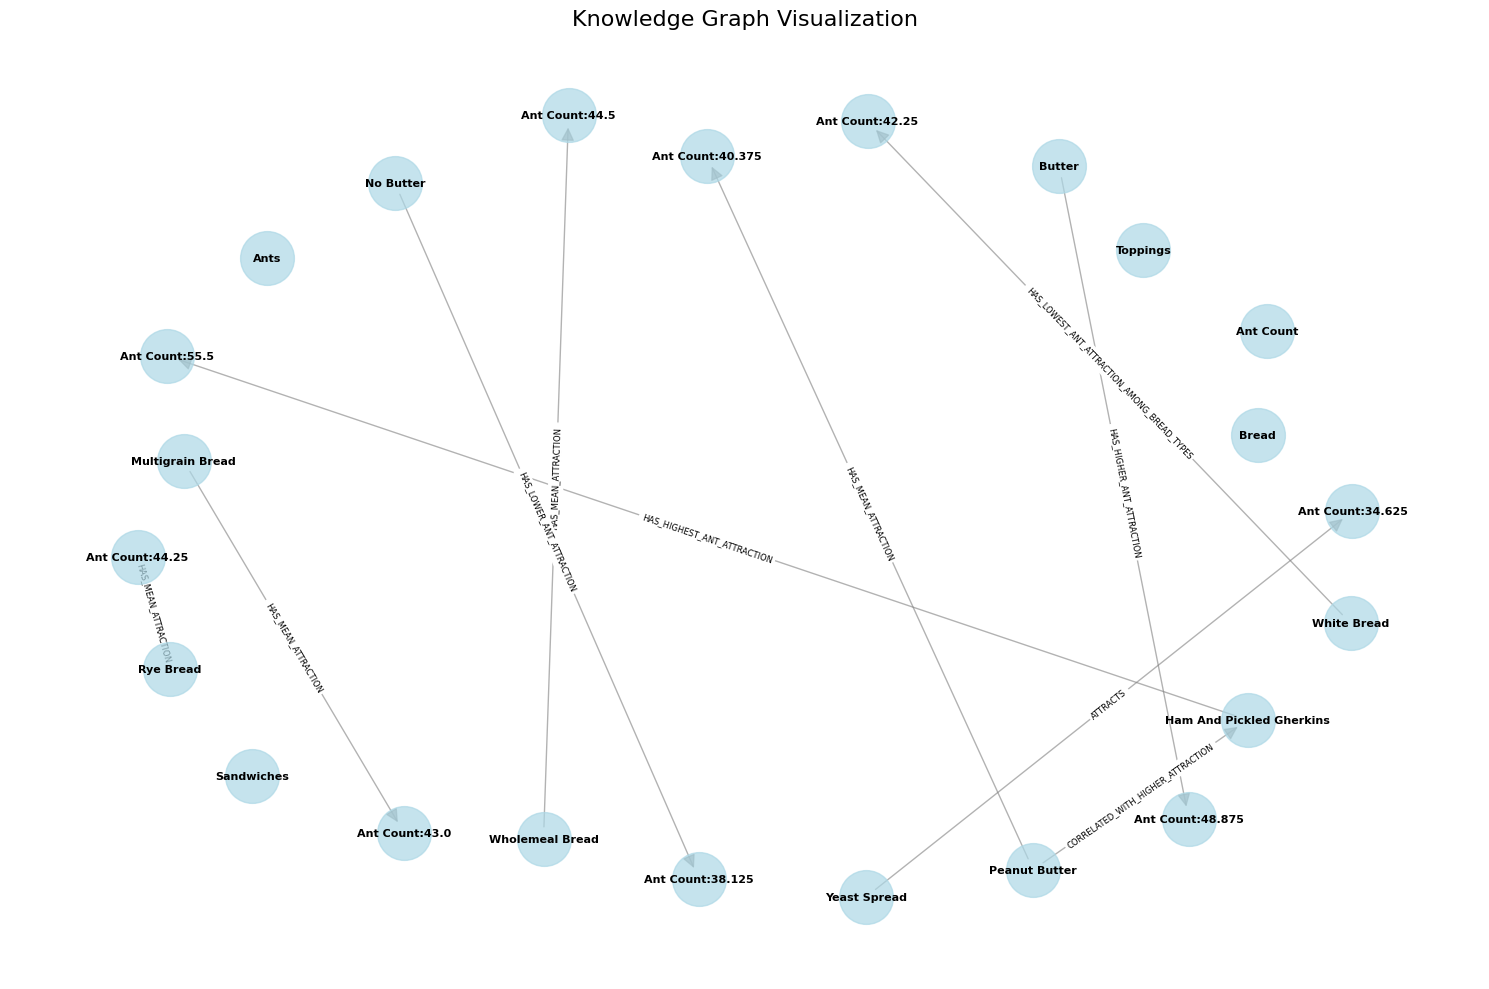

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for graph_doc in graph:
    for node in graph_doc.nodes:
        G.add_node(node.id, type=node.type)
    
    for rel in graph_doc.relationships:
        G.add_edge(rel.source.id, rel.target.id, label=rel.type)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=3, iterations=50)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                        node_size=1500, alpha=0.7)

nx.draw_networkx_edges(G, pos, edge_color='gray', 
                        arrows=True, arrowsize=20, alpha=0.6)

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

plt.title("Knowledge Graph Visualization", size=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [50]:
query = "What are the major reasons of ant attraction?"

In [51]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

node_texts = [node.id for graph_doc in graph for node in graph_doc.nodes]

node_embeddings = model.encode(node_texts, convert_to_tensor=True)
query_embedding = model.encode(query, convert_to_tensor=True)

scores = util.pytorch_cos_sim(query_embedding, node_embeddings)[0].cpu().numpy()

top_k = 5
top_indices = np.argsort(scores)[::-1][:top_k]

top_k_nodes = [node_texts[i] for i in top_indices]


In [55]:
top_k_nodes

['Ants', 'Ant Count', 'Peanut Butter', 'Butter', 'Bread']

In [52]:
def traverse_and_find_answer(G, query_embedding, start_nodes, max_hops=3, model=None):
    visited = set()
    subgraph_nodes = set(start_nodes)

    for hop in range(max_hops):
        next_nodes = set()
        for node in subgraph_nodes:
            neighbors = list(G.successors(node)) + list(G.predecessors(node))
            for nbr in neighbors:
                if nbr not in visited:
                    next_nodes.add(nbr)
        visited |= subgraph_nodes
        subgraph_nodes |= next_nodes

        # Check if answer is present in this subgraph
        node_texts = list(subgraph_nodes)
        node_embeddings = model.encode(node_texts, convert_to_tensor=True)
        score = util.pytorch_cos_sim(query_embedding, node_embeddings)
        if score.max().item() > 0.7:  # arbitrary threshold
            return subgraph_nodes

    return subgraph_nodes  # return what you have even if confidence is low


In [60]:
# Convert node names and edge relations into a readable string
def subgraph_to_text(G, nodes):
    text = []
    for n in nodes:
        for succ in G.successors(n):
            rel = G.get_edge_data(n, succ)['label']
            text.append(f"{n} --{rel}--> {succ}")
    return "\n".join(text)

subgraph = traverse_and_find_answer(G, query_embedding, top_k_nodes, model=model)
context = subgraph_to_text(G, subgraph)

llm_query = f"""
You are a skilled data analyst.

Given the following knowledge graph, your job is to analyze **key metrics and performance indicators** and generate a detailed report explaining:

- Important metric values and trends (e.g., high/low counts, anomalies).
- Entities and attributes contributing to changes in those metrics.
- Possible **causal** or **correlational** relationships between entities and metrics.
- Business or operational insights inferred from the data.

This graph may represent various metrics (e.g., GMV, CTR, Clicks, Count, Conversions, etc.) and entities (e.g., toppings, time of day, user segments).

---

**Knowledge Graph Input:**
{context}

---

**Report Format:**
- [Section 1: Key Metrics Observed]
- [Section 2: Factors Associated With Metric Changes]
- [Section 3: Inferred Insights and Explanations]
- [Optional: Recommendations if relevant]

Only use information from the graph. Do not invent unsupported assumptions.
"""




In [61]:
subgraph

{'Ant Count',
 'Ant Count:40.375',
 'Ant Count:48.875',
 'Ant Count:55.5',
 'Ants',
 'Bread',
 'Butter',
 'Ham And Pickled Gherkins',
 'Peanut Butter'}

In [62]:
response = llm.invoke(llm_query)
print(response.content)  # This gives you the actual answer

## **Key Metrics Observed**

The knowledge graph provides data on the ant attraction of various food items, quantified by an "Ant Count" metric. The key metrics observed are:

- **Ham And Pickled Gherkins**: Has the highest ant attraction with an Ant Count of **55.5**.
- **Butter**: Has a high ant attraction with an Ant Count of **48.875**.
- **Peanut Butter**: Has a mean ant attraction with an Ant Count of **40.375**.

## **Factors Associated With Metric Changes**

Based on the provided data:

- **Entities and Attributes**:
  - **Ham And Pickled Gherkins**, **Butter**, and **Peanut Butter** are the food items (entities) with varying levels of ant attraction.
  - The attributes are the **Ant Count** values associated with each food item.

- **Trends and Anomalies**:
  - **Ham And Pickled Gherkins** has the highest Ant Count at **55.5**, indicating a strong attraction for ants.
  - **Butter** follows with an Ant Count of **48.875**, suggesting a significant but lower attraction compared

In [ ]:
%pip install python-docx
%pip install sentence-transformers
%pip install huggingface_hub
%pip install openai
%pip install json-repair
%pip install groq
%pip install langchain langchain-experimental langchainhub langchain-core langchain-community langchain-groq

import os 
from langchain.chat_models import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from docx import Document as docx_doc
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import numpy as np

# llm_openai = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     api_key="sk-proj-4yNXnoOAqe7ifcyS1ecQVbfg1GaG6C1nO-EC0J_LQQbPvL_5ZTHYf0c5zTK-" \
#         "CeQvcranVLNsQUT3BlbkFJjUJLdI0LQ6j46IlciENDKb9vYe3x47UpR_OPbaAotubgbM5htrTrpYvpGDMck3pLYZbaQOMpgA",  # if you prefer to pass api key in directly instaed of using env vars
# )

os.environ["GROQ_API_KEY"] = ""

llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.3
)


def extract_chunks_by_heading(file_path):
    doc = docx_doc(file_path)
    chunks = []
    current_heading = "No Heading"
    current_text = []

    for para in doc.paragraphs:
        if para.style.name.startswith("Heading"):
            # Save previous chunk before starting a new one
            if current_text:
                chunks.append(Document(page_content="\n".join(current_text), metadata={"heading": current_heading}))
            current_heading = para.text.strip()
            current_text = []
        else:
            if para.text.strip():
                current_text.append(para.text.strip())

    # Add final chunk
    if current_text:
        chunks.append(Document(page_content="\n".join(current_text), metadata={"heading": current_heading}))

    return chunks

custom_prompt = ChatPromptTemplate.from_template(
    """You are an expert Knowledge Graph Builder and Data Analyst.

Given the following text (which may contain tables, structured data, or paragraphs), extract a **comprehensive set of relationships and insights**, including:

### 1. Entities:
- Real-world items, objects, or concepts mentioned in the text.
- Use **exact phrases** from the input.

### 2. Attributes & Metrics:
- Quantities, mean values, measurements (e.g., "Ant Count: 55.5").
- Include units if specified.

### 3. Relationships:
- Between entities (e.g., "Sandwich —[CONTAINS]→ Butter").
- Between data and entities (e.g., "Butter —[ASSOCIATED_WITH_HIGHER_ANT_COUNT]→ Ant Count: 55.5").

### 4. Analytical Inference:
- Infer insights from **tabular or numeric data**.
- Example:
  - If "Peanut Butter" has the **highest mean ant count**, then add:
    `Peanut Butter —[HAS_HIGHEST_ANT_ATTRACTION]→ Ant Count: 55.5`
  - If "White Bread" has the **lowest mean ant count**, add:
    `White Bread —[HAS_LOWEST_ANT_ATTRACTION]→ Ant Count: 38.1`

### 5. Subcomponents & Hierarchies:
- E.g., "Sandwich —[TOPPED_WITH]→ Ham"
- E.g., "Toppings —[INCLUDES]→ Pickled Gherkins"

### Output Format:
- Use this format for each relationship:
  `Entity A —[Relation]→ Entity B`

- Include analytical facts as their own edges (use meaningful relation names like `HAS_MAX_COUNT`, `CORRELATED_WITH`, etc).

### If nothing meaningful is found, return: []
  
Text:
{input}

Output:
"""
)

def extract_text_from_docx(file_path):
    doc = docx_doc(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return "\n".join(full_text)

heading_chunks = extract_chunks_by_heading("Untitled document.docx")


file_path = "Untitled document.docx" # CHANGE PATH
# text = extract_text_from_docx(file_path)

graph_transformer = LLMGraphTransformer(llm=llm, prompt=custom_prompt)

# doc = [Document(page_content=text)]
graph = graph_transformer.convert_to_graph_documents(heading_chunks)

G = nx.DiGraph()

for graph_doc in graph:
    for node in graph_doc.nodes:
        G.add_node(node.id, type=node.type)
    
    for rel in graph_doc.relationships:
        G.add_edge(rel.source.id, rel.target.id, label=rel.type)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=3, iterations=50)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                        node_size=1500, alpha=0.7)

nx.draw_networkx_edges(G, pos, edge_color='gray', 
                        arrows=True, arrowsize=20, alpha=0.6)

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

plt.title("Knowledge Graph Visualization", size=16)
plt.axis('off')
plt.tight_layout()
plt.show()

model = SentenceTransformer('all-MiniLM-L6-v2')

node_texts = [node.id for graph_doc in graph for node in graph_doc.nodes]

node_embeddings = model.encode(node_texts, convert_to_tensor=True)
query_embedding = model.encode(query, convert_to_tensor=True)

scores = util.pytorch_cos_sim(query_embedding, node_embeddings)[0].cpu().numpy()

top_k = 5
top_indices = np.argsort(scores)[::-1][:top_k]

top_k_nodes = [node_texts[i] for i in top_indices]

def traverse_and_find_answer(G, query_embedding, start_nodes, max_hops=3, model=None):
    visited = set()
    subgraph_nodes = set(start_nodes)

    for hop in range(max_hops):
        next_nodes = set()
        for node in subgraph_nodes:
            neighbors = list(G.successors(node)) + list(G.predecessors(node))
            for nbr in neighbors:
                if nbr not in visited:
                    next_nodes.add(nbr)
        visited |= subgraph_nodes
        subgraph_nodes |= next_nodes

        # Check if answer is present in this subgraph
        node_texts = list(subgraph_nodes)
        node_embeddings = model.encode(node_texts, convert_to_tensor=True)
        score = util.pytorch_cos_sim(query_embedding, node_embeddings)
        if score.max().item() > 0.7:  # arbitrary threshold
            return subgraph_nodes

    return subgraph_nodes  # return what you have even if confidence is low

# Convert node names and edge relations into a readable string
def subgraph_to_text(G, nodes):
    text = []
    for n in nodes:
        for succ in G.successors(n):
            rel = G.get_edge_data(n, succ)['label']
            text.append(f"{n} --{rel}--> {succ}")
    return "\n".join(text)

subgraph = traverse_and_find_answer(G, query_embedding, top_k_nodes, model=model)
context = subgraph_to_text(G, subgraph)

llm_query = f"""
You are a skilled data analyst.

Given the following knowledge graph, your job is to analyze **key metrics and performance indicators** and generate a detailed report explaining:

- Important metric values and trends (e.g., high/low counts, anomalies).
- Entities and attributes contributing to changes in those metrics.
- Possible **causal** or **correlational** relationships between entities and metrics.
- Business or operational insights inferred from the data.

This graph may represent various metrics (e.g., GMV, CTR, Clicks, Count, Conversions, etc.) and entities (e.g., toppings, time of day, user segments).

---

**Knowledge Graph Input:**
{context}

---

**Report Format:**
- [Section 1: Key Metrics Observed]
- [Section 2: Factors Associated With Metric Changes]
- [Section 3: Inferred Insights and Explanations]
- [Optional: Recommendations if relevant]

Only use information from the graph. Do not invent unsupported assumptions.
"""

response = llm.invoke(llm_query)
print(response.content)  # This gives you the actual answer




